In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200

In [2]:
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [3]:
!pip install seaborn -q -q
!pip install geohash2 -q -q

In [4]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from keplergl import KeplerGl
import random

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

import geohash2
import json

In [5]:
schema = 'ds_data_for_complexity'

In [6]:
stops_table_name = f'dedicated.{schema}.selected_stops_limited'
device_location_table_name = f'dedicated.{schema}.device_location_and_stops_limited'
feature_table_name = f'dedicated.ds_data_for_complexity.device_location_and_stops_for_model_part3'

In [7]:
df_false_positive = pd.read_csv("false_positive_last.csv")
df_true_negative = pd.read_csv("true_negative_last.csv")

In [8]:
# Unique key generation concatenating ID and timestamp

df_false_positive['key'] = df_false_positive['lineage_id'].astype(str) + '_' + df_false_positive['event_zoned_datetime'].astype(str)
df_true_negative['key'] = df_true_negative['lineage_id'].astype(str) + '_' + df_true_negative['event_zoned_datetime'].astype(str)

In [9]:
# Key for device and device-timestamp for true positives

tuple_key_pos =tuple(df_false_positive['key'].values)
tuple_device_pos =tuple(set(df_false_positive['lineage_id'].values))

# Key for device and device-timestamp for true negative, subsampling 10000 id 

tuple_key_neg =tuple(df_true_negative['key'].values)
tuple_key_neg_subsample = tuple(random.sample(tuple(df_true_negative['key'].values),20000))
tuple_device_neg =tuple(set(df_true_negative['lineage_id'].values))

In [10]:
# Query for spot min distance between each false positive points and the nearest actual stop point.

query = f"""
    with stops as (
        select lineage_id,
                stop_id, lat, lng,
                stop_start_unix_timestamp,
                dwell_time_minutes,
                stop_end_unix_timestamp
        from {stops_table_name}
        where lineage_id in {tuple_device_neg}
        and stop_id NOT IN (SELECT distinct stop_id FROM {device_location_table_name} WHERE subsampled = 1)

    
    ),
    
    false_positive as (
        select lineage_id,
               lat as fp_lat,
               lng as fp_lng,
               event_timestamp as fp_event_timestamp
        from {device_location_table_name}
        where concat(cast(lineage_id as varchar) , '_', cast(event_zoned_datetime as varchar)) 
        in {tuple_key_neg_subsample}
    ),
    
    joined_table as(
        select fp.*,
               s.stop_id, 
               s.lat as stop_lat, 
               s.lng as stop_lng,
                s.stop_start_unix_timestamp,
                s.dwell_time_minutes,
                s.stop_end_unix_timestamp
        from false_positive fp
        join stops s
            on fp.lineage_id = s.lineage_id
    
    ),
    
    final_table as(
        select distinct
            *,
            6371000 * 2 * ASIN(SQRT(
            POWER(SIN(RADIANS(fp_lat - stop_lat) / 2), 2) +
            COS(RADIANS(stop_lat)) * COS(RADIANS(fp_lat)) *
            POWER(SIN(RADIANS(fp_lng - stop_lng) / 2), 2)
            )) AS distance_meters,
            abs((cast(fp_event_timestamp as double) - cast(stop_start_unix_timestamp as double))/60.) as distance_min
        from joined_table
    )
    
    select distinct *
    from final_table
"""
df_tn = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


In [11]:
# Query for spot min distance between each true negative points and the nearest actual stop point.

query = f"""
    with stops as (
        select lineage_id,
                stop_id, lat, lng,
                stop_start_unix_timestamp,
                dwell_time_minutes,
                stop_end_unix_timestamp
        from {stops_table_name}
        where lineage_id in {tuple_device_pos}
        and stop_id NOT IN (SELECT distinct stop_id FROM {device_location_table_name} WHERE subsampled = 1)

    
    ),
    
    false_positive as (
        select lineage_id,
               lat as fp_lat,
               lng as fp_lng,
               event_timestamp as fp_event_timestamp
        from {device_location_table_name}
        where concat(cast(lineage_id as varchar) , '_', cast(event_zoned_datetime as varchar)) 
        in {tuple_key_pos}
    ),
    
    joined_table as(
        select fp.*,
               s.stop_id, 
               s.lat as stop_lat, 
               s.lng as stop_lng,
               s.stop_start_unix_timestamp,
               s.dwell_time_minutes,
               s.stop_end_unix_timestamp
        from false_positive fp
        join stops s
            on fp.lineage_id = s.lineage_id
    
    ),
    
    final_table as(
        select distinct
            *,
            6371000 * 2 * ASIN(SQRT(
            POWER(SIN(RADIANS(fp_lat - stop_lat) / 2), 2) +
            COS(RADIANS(stop_lat)) * COS(RADIANS(fp_lat)) *
            POWER(SIN(RADIANS(fp_lng - stop_lng) / 2), 2)
            )) AS distance_meters,
            abs((cast(fp_event_timestamp as double) - cast(stop_start_unix_timestamp as double))/60.) as distance_min
        from joined_table
    )
    
    select distinct *
    from final_table
"""
df_fp = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


In [12]:
# Compute the min aggregating by ID and timestamp

columns = ['lineage_id', 'fp_event_timestamp']
df_fp_grouped = df_fp.groupby(columns)[['distance_meters', 'distance_min']].agg('min').reset_index()
df_tn_grouped = df_tn.groupby(columns)[['distance_meters', 'distance_min']].agg('min').reset_index()

In [13]:
# Statistical description for false positive

df_fp_grouped.describe()

,lineage_id,fp_event_timestamp,distance_meters,distance_min
count,1.419200e+04,1.419200e+04,14192.000000,14192.000000
mean,9.223372e+18,1.711579e+09,100.798247,175.455764
std,1.612577e+09,2.443540e+05,1130.633144,962.737762
min,9.223372e+18,1.711167e+09,0.000000,0.016667
25%,9.223372e+18,1.711384e+09,2.232137,6.650000
50%,9.223372e+18,1.711554e+09,7.718711,19.833333
75%,9.223372e+18,1.711803e+09,25.010016,61.266667
max,9.223372e+18,1.712016e+09,79376.211876,15805.933333


In [14]:
# Statistical description for true negative

df_tn_grouped.describe()

,lineage_id,fp_event_timestamp,distance_meters,distance_min
count,1.981300e+04,1.981300e+04,19813.000000,19813.000000
mean,9.223372e+18,1.711599e+09,3258.848641,126.846741
std,1.539235e+09,2.517057e+05,6133.146130,591.233040
min,9.223372e+18,1.711167e+09,0.000000,0.050000
25%,9.223372e+18,1.711381e+09,391.329917,12.850000
50%,9.223372e+18,1.711577e+09,1290.562858,30.533333
75%,9.223372e+18,1.711817e+09,3516.675524,77.950000
max,9.223372e+18,1.712016e+09,78607.583755,15883.083333


Text(0.5, 9.444444444444438, 'Minimum distance to the nearest stop (m)')

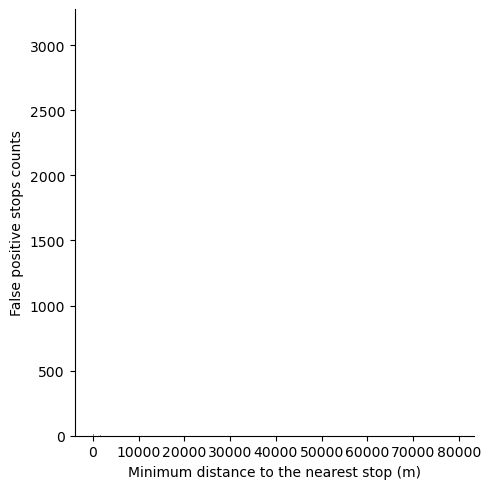

In [15]:
# Plot the histogram thanks to the displot function
sns.displot( data=df_fp_grouped['distance_meters'])

plt.ylabel('False positive stops counts')
plt.xlabel('Minimum distance to the nearest stop (m)')

#plt.xlim(-10, 10)
#plt.ylim(-10, 10)
#plt.savefig('plot2.png')

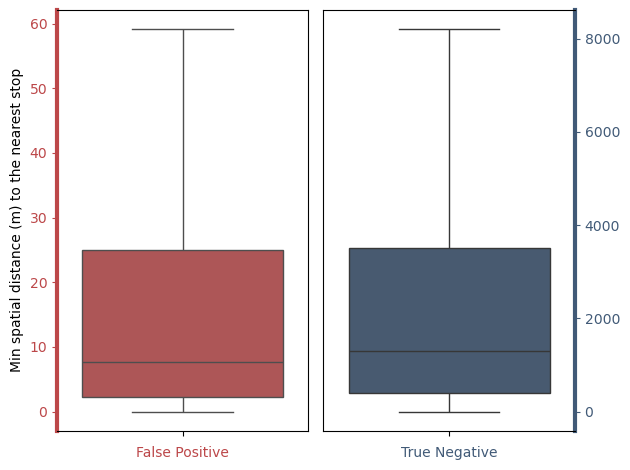

In [16]:
# Boxplot compared for false positive and true negative 

fig, axes = plt.subplots(1, 2, sharex=True)#, sharey= True)
#fig.suptitle('Results analysis', fontsize=16)

col1 = '#bc4749'
col2 = '#415a77'

sns.boxplot(data=df_fp_grouped['distance_meters'], showfliers = False, ax = axes[0], color = col1)
#sns.boxplot(data=df_fp_grouped['distance_min'], showfliers = False, ax = axes[1,0])

sns.boxplot(data=df_tn_grouped['distance_meters'], showfliers = False, ax = axes[1], color = col2)
#sns.boxplot(data=df_tn_grouped['distance_min'], showfliers = False, ax = axes[1,1])

axes[0].set_ylabel('Min spatial distance (m) to the nearest stop')
axes[1].set_ylabel('')

axes[0].set_xlabel('False Positive')
axes[1].set_xlabel('True Negative')
axes[1].yaxis.set_ticks_position('right')

axes[0].spines['left'].set_color(col1)
axes[0].spines['left'].set_linewidth(3)
axes[0].xaxis.label.set_color(col1)
axes[0].tick_params(axis='y', colors=col1)


axes[1].spines['right'].set_color(col2)
axes[1].spines['right'].set_linewidth(3)
axes[1].xaxis.label.set_color(col2)
axes[1].tick_params(axis='y', colors=col2)

plt.tight_layout()
plt.savefig('fp_tn_analysis.png', dpi=300)
